In [5]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [7]:
from sklearn.metrics import mean_squared_error, r2_score

# DataFrame to store all results
results_df = pd.DataFrame(columns=['Batch', 'evalt', 'Low Similarity Count', 'Novelty Error'])


# Load the DataFrame from a CSV file
test_df =  pd.read_csv("output/logp_sorted_fcv_results_RF_testing batches.csv")
train_df =  pd.read_csv("output/logp_sorted_fcv_results_RF_training batches.csv")

# Precompute fingerprints for training set
train_df['Fingerprint'] = train_df['Standardized_SMILES'].parallel_apply(
    lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=2)
)

# Function to find max similarity with batch optimization
def max_tanimoto(test_smile, train_fps):
    test_mol = Chem.MolFromSmiles(test_smile)
    test_fp = AllChem.GetMorganFingerprintAsBitVect(test_mol, radius=2)
    return max(DataStructs.TanimotoSimilarity(test_fp, train_fp) for train_fp in train_fps)

# Analyze each batch
for batch in test_df['testing batch'].unique():
    test_batch = test_df[test_df['testing batch'] == batch]
    train_batch = train_df[train_df['training batch'] == batch]
    train_fps = train_batch['Fingerprint'].tolist()

    low_similarity_smiles = []
    errors = []

    for idx, test_row in test_batch.iterrows():
        max_similarity = max_tanimoto(test_row['Standardized_SMILES'], train_fps)

        if max_similarity < 0.55:
            low_similarity_smiles.append(test_row['Standardized_SMILES'])
            error = abs(test_row['y_true'] - test_row['y_preds'])
            errors.append(error)

    # Calculate the average error for low similarity compounds
    average_error = np.mean(errors) if errors else 0

    print(f"Batch {batch}: Number of low similarity SMILES = {len(low_similarity_smiles)}, Average Error = {average_error:.2f}")


    results_df = results_df.append({
        'Batch': batch,
        'evalt': "sorted_fcv",
        'Low Similarity Count': len(low_similarity_smiles),
        'Novelty Error': average_error
    }, ignore_index=True)

# Optionally, save the results DataFrame to a CSV file
results_df.to_csv('metrics/novelty_error_sorted_fcv_results.csv', index=False)

# Display the results DataFrame
results_df

Batch 1: Number of low similarity SMILES = 77, Average Error = 29.10
Batch 2: Number of low similarity SMILES = 70, Average Error = 22.05
Batch 3: Number of low similarity SMILES = 74, Average Error = 21.38
Batch 4: Number of low similarity SMILES = 71, Average Error = 22.43
Batch 5: Number of low similarity SMILES = 65, Average Error = 21.20
Batch 6: Number of low similarity SMILES = 69, Average Error = 22.13
Batch 7: Number of low similarity SMILES = 70, Average Error = 29.12
Batch 8: Number of low similarity SMILES = 79, Average Error = 26.16
Batch 9: Number of low similarity SMILES = 88, Average Error = 22.63


,Batch,evalt,Low Similarity Count,Novelty Error
0,1,sorted_fcv,77,29.096012
1,2,sorted_fcv,70,22.045431
2,3,sorted_fcv,74,21.376275
3,4,sorted_fcv,71,22.432383
4,5,sorted_fcv,65,21.199491
5,6,sorted_fcv,69,22.125110
6,7,sorted_fcv,70,29.122384
7,8,sorted_fcv,79,26.156652
8,9,sorted_fcv,88,22.625219


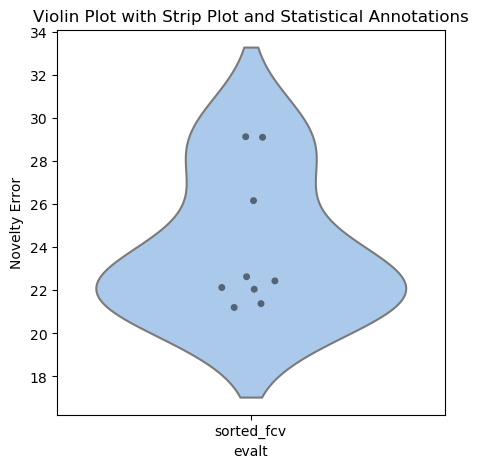

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# Set up the matplotlib figure
plt.figure(figsize=(5, 5), dpi=100)

# Create violin plot with strip plot overlay
sns.violinplot(x="evalt", y="Novelty Error", data=results_df, inner=None, palette="pastel")
sns.stripplot(x="evalt", y="Novelty Error", data=results_df, jitter=True, color="black", alpha=0.5)

plt.title("Violin Plot with Strip Plot and Statistical Annotations")
plt.show()


No handles with labels found to put in legend.


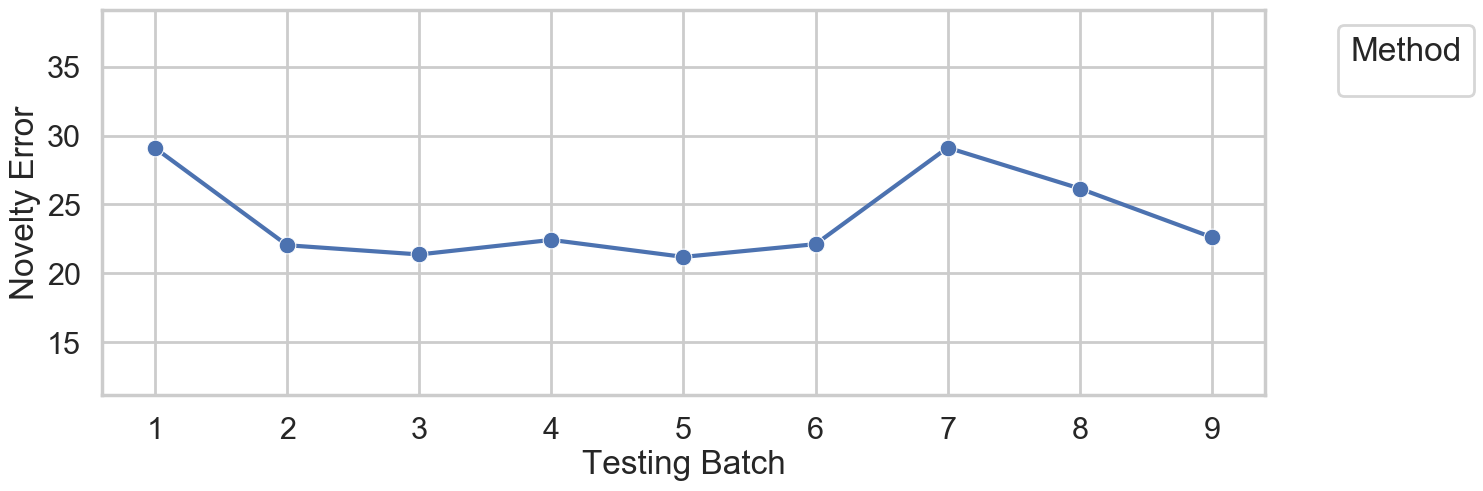

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

sns.set_context("poster")

# First, determine the global minimum and maximum Discovery Yield values to set the y-axis limits
global_min = results_df['Novelty Error'].min()-10
global_max = results_df['Novelty Error'].max()+10


# Set up the visualization
plt.figure(figsize=(15, 5), dpi=100)

# Create a line plot with scatter points
sns.lineplot(data=results_df, x='Batch', y='Novelty Error', 
             marker='o', palette='Set1', markers=True,  dashes=False)

# Customize the plot
plt.xlabel('Testing Batch')
plt.ylabel('Novelty Error')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set the y-axis limits based on the global min and max values
plt.ylim(global_min, global_max)

# Show the plot
plt.show()